# KNN for Dataset Adult

PMR3508 - Aprendizado de Máquina e Reconhecimento de Padrões

Testando kNN com a base adult obtida no UCI repository. Iniciando com carregamento da base e com análise básica da base e dos atributos.

Tarefa: construir classificador para a variável "Target (<=50K or >50K) com KNN

Autor: Eduardo AV Salis


## 1. Bibliotecas Básicas

In [243]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

----

## 2. Dataset

In [200]:
df_train = pd.read_csv("train_data.csv", na_values='?')

In [201]:
df_train.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


In [202]:
#df_train.drop("Id",axis=1,inplace=True)

In [203]:
df_train.describe()

,Id,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32560.000000,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,32559.500000,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,9399.406719,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,16280.000000,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,24419.750000,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,32559.500000,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,40699.250000,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,48839.000000,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [204]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              32560 non-null  int64 
 1   age             32560 non-null  int64 
 2   workclass       30724 non-null  object
 3   fnlwgt          32560 non-null  int64 
 4   education       32560 non-null  object
 5   education.num   32560 non-null  int64 
 6   marital.status  32560 non-null  object
 7   occupation      30717 non-null  object
 8   relationship    32560 non-null  object
 9   race            32560 non-null  object
 10  sex             32560 non-null  object
 11  capital.gain    32560 non-null  int64 
 12  capital.loss    32560 non-null  int64 
 13  hours.per.week  32560 non-null  int64 
 14  native.country  31977 non-null  object
 15  income          32560 non-null  object
dtypes: int64(7), object(9)
memory usage: 4.0+ MB


In [205]:
df_train.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


In [206]:
df_train.shape

(32560, 16)

----

## 3. EDA

### 3.1 Categóricas

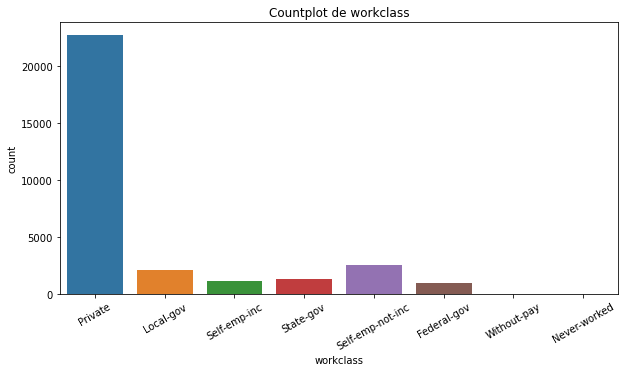

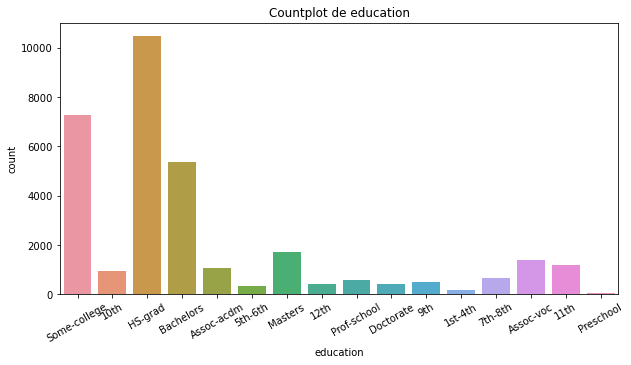

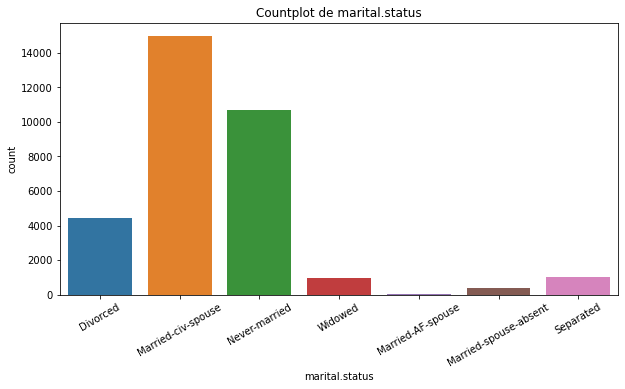

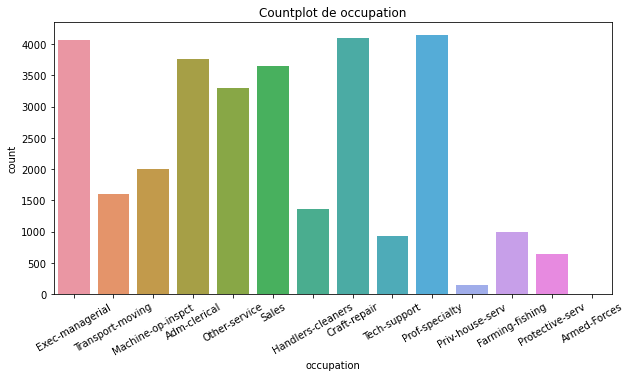

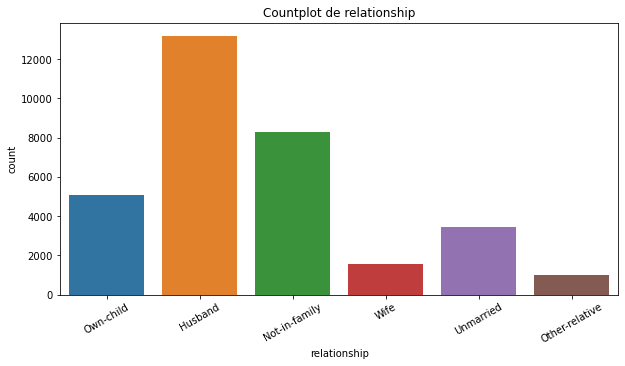

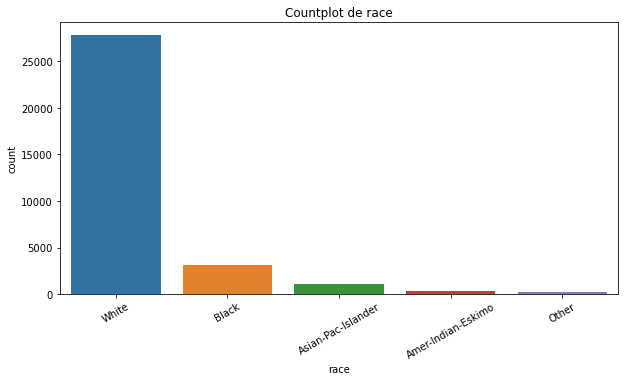

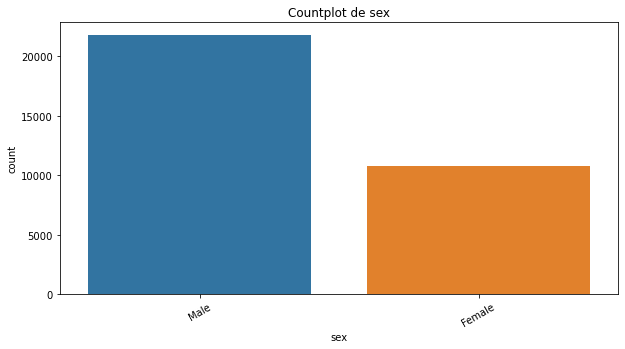

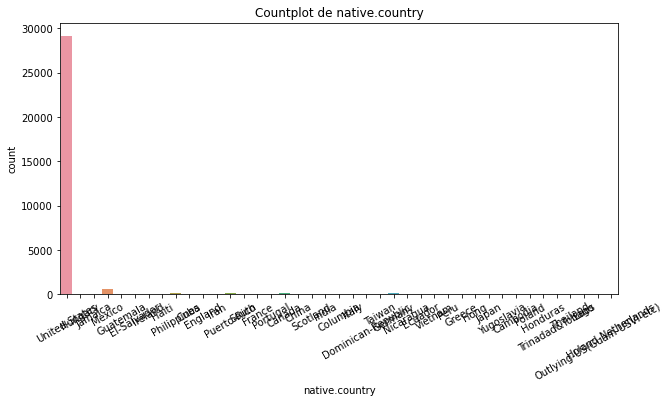

In [207]:
categ = ['workclass','education',"marital.status","occupation","relationship","race","sex","native.country"]
for feature in categ:
    plt.figure(figsize=(10,5))
    plt.title(f'Countplot de {feature}')
    ax = sns.countplot(x=feature ,data = df_train)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    plt.show()

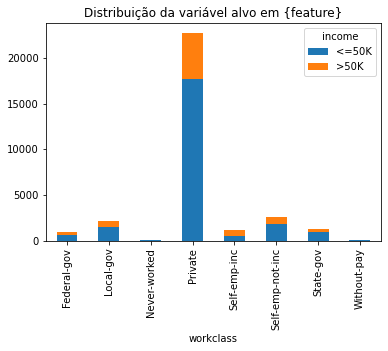

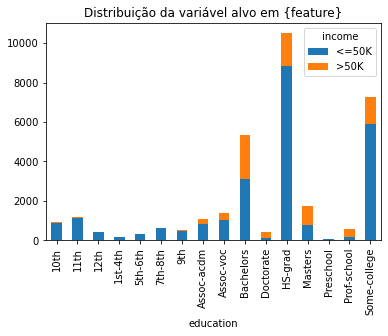

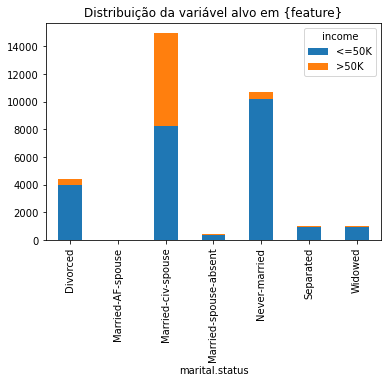

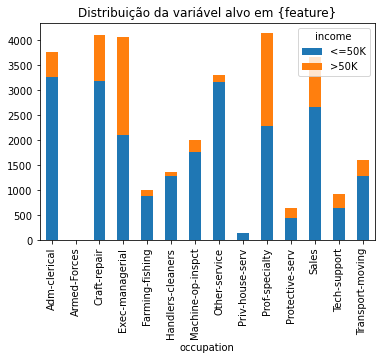

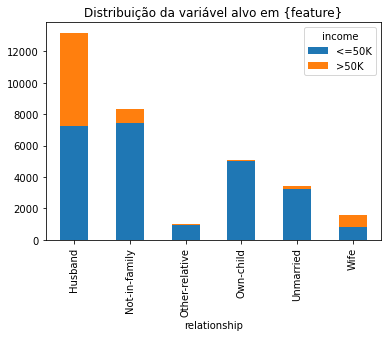

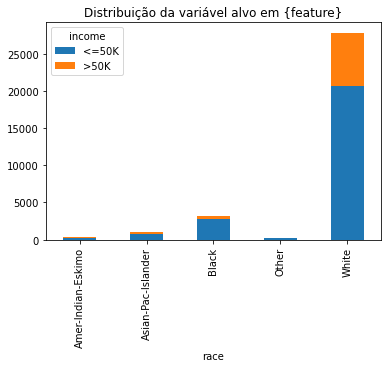

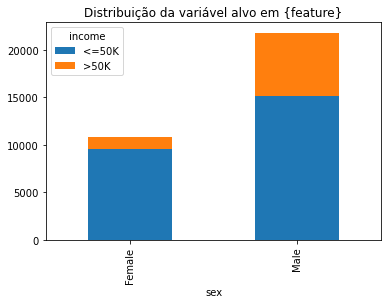

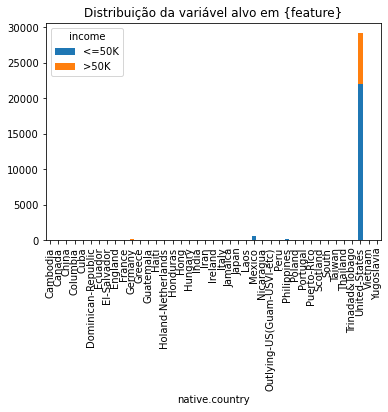

In [208]:
for feature in categ:
    df_train.groupby(['income', feature]).size().reset_index().pivot(columns='income', index=feature, values=0).plot(
        kind='bar', stacked=True, title="Distribuição da variável alvo em {feature}")
    #plt.show()

### 3.2 Variáveis numéricas

<Figure size 720x360 with 0 Axes>

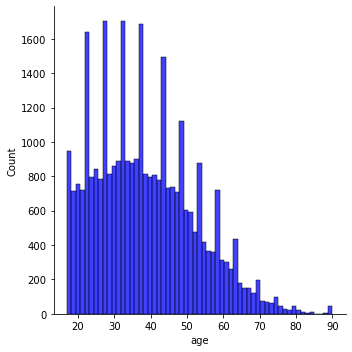

In [209]:
plt.figure(figsize=(10,5))
ax = sns.displot(df_train.age, kde=False, color='blue')

<Figure size 720x360 with 0 Axes>

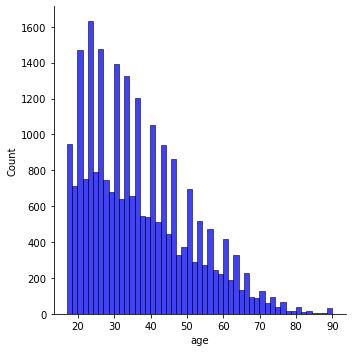

In [210]:
plt.figure(figsize=(10,5))
ax = sns.displot(df_train[df_train['income'] =="<=50K"].age, kde=False, color='blue')

<Figure size 720x360 with 0 Axes>

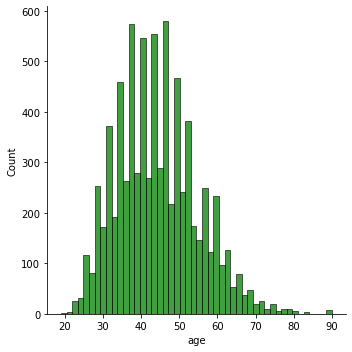

In [211]:
plt.figure(figsize=(10,5))
ax = sns.displot(df_train[df_train['income'] ==">50K"].age, kde=False, color='green')

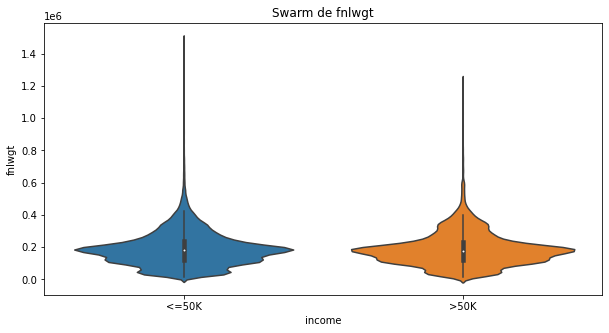

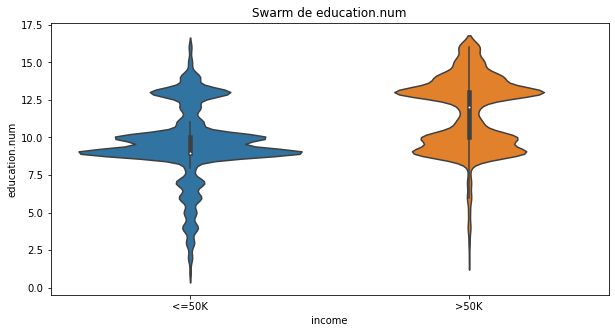

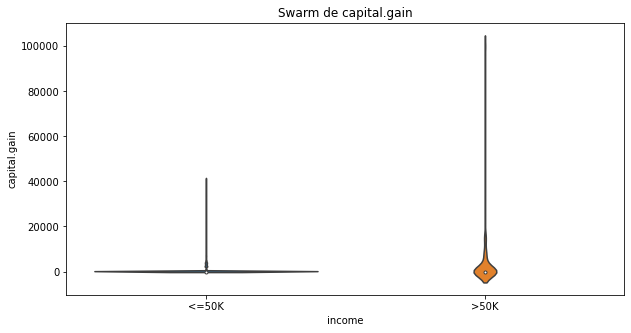

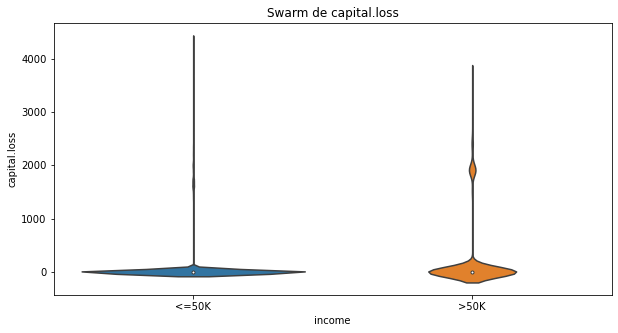

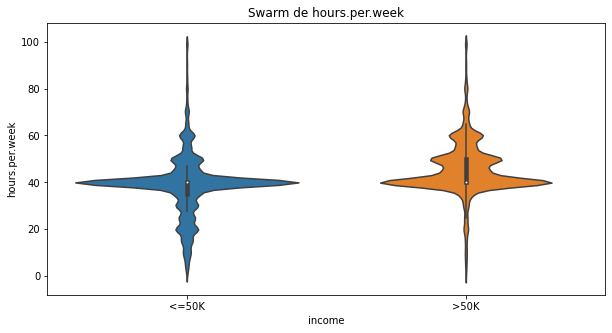

In [212]:
numeric = ['fnlwgt','education.num',"capital.gain","capital.loss","hours.per.week"]
for feature in numeric:
    plt.figure(figsize=(10,5))
    plt.title(f'Swarm de {feature}')
    ax = sns.violinplot(x="income", y=feature ,data = df_train)
    plt.show()


### 3.3 Dados do alvo desbalanceados

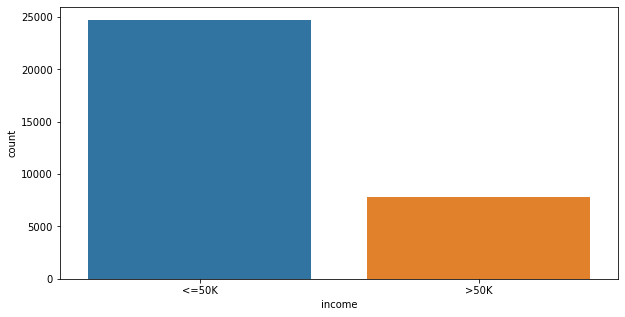

In [213]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x='income' ,data = df_train)

----

## 4 Pre - processamento

In [214]:

df_train['income'] = df_train['income'].replace({
    "<=50K": 0, 
    ">50K":1 
}) 


### 4.1 Lidando com dados nulos

In [215]:
#Caso retira-se todos os nulos perderia 13% das observações
print(df_train.isna().sum().sum()/df_train.shape[0])

0.13089680589680588


In [216]:
#verificando a proporção entre as colunas
print(round(df_train.isna().sum()/df_train.shape[0],2))

Id                0.00
age               0.00
workclass         0.06
fnlwgt            0.00
education         0.00
education.num     0.00
marital.status    0.00
occupation        0.06
relationship      0.00
race              0.00
sex               0.00
capital.gain      0.00
capital.loss      0.00
hours.per.week    0.00
native.country    0.02
income            0.00
dtype: float64


Substituindo os valores nulos pelos mais frequentes

In [217]:
imp = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')

In [218]:
df_train['workclass'] = imp.fit_transform(df_train['workclass'].values.reshape(-1,1))[:,0]
df_train['occupation'] = imp.fit_transform(df_train['occupation'].values.reshape(-1,1))[:,0]
df_train['native.country'] = imp.fit_transform(df_train['native.country'].values.reshape(-1,1))[:,0]

### 4.2 Tratando variáveis categóricas

In [219]:
labelencoder = LabelEncoder()

In [220]:
categ

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

In [221]:
for feature in categ:
    df_train[feature]= labelencoder.fit_transform(df_train[feature])

### 4.3 Seleção e "engenharia" de atributos

In [222]:
#penso que as variáveis education e education.num são redundantes
df_train.drop("education",axis=1, inplace=True)

In [223]:
df_train['capital_diff'] = df_train['capital.gain'].sub(df_train['capital.loss'])

In [225]:
df_train.drop(["capital.gain","capital.loss"],axis=1, inplace=True)

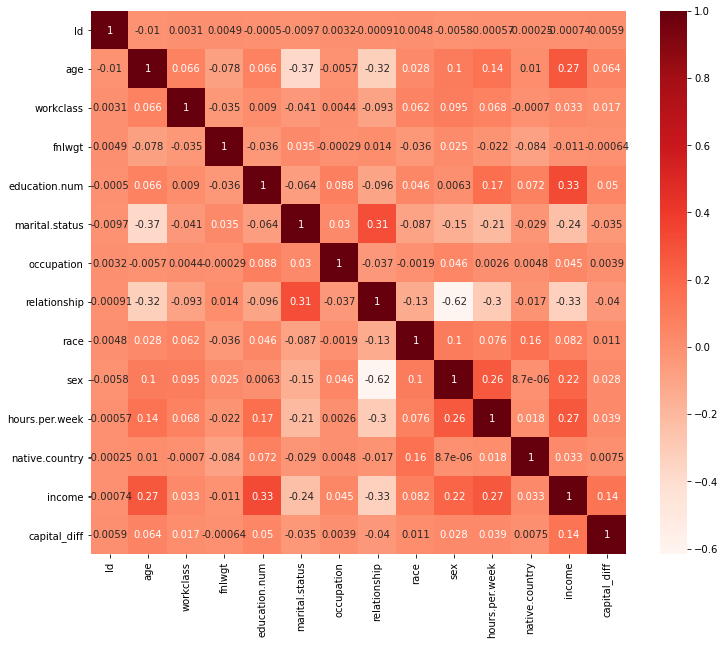

In [226]:
plt.figure(figsize=(12,10))
cor = df_train.corr(method="spearman")
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### 4.4 Padronizando variáveis numéricas 

In [227]:
scaler = StandardScaler()

In [228]:
df_train[['fnlwgt', 'education.num', 'capital_diff', 'hours.per.week']] = scaler.fit_transform(df_train[['fnlwgt', 'education.num', 'capital_diff', 'hours.per.week']])

----

## 5 Aplicação do KNN classifier

### 5.1 Importando base de teste e aplicando o preprocessamento da base de treino

In [229]:
df_test = pd.read_csv("test_data.csv", na_values='?')

In [230]:
df_test['workclass'] = imp.fit_transform(df_test['workclass'].values.reshape(-1,1))[:,0]
df_test['occupation'] = imp.fit_transform(df_test['occupation'].values.reshape(-1,1))[:,0]
df_test['native.country'] = imp.fit_transform(df_test['native.country'].values.reshape(-1,1))[:,0]

In [231]:
for feature in categ:
    df_test[feature]= labelencoder.fit_transform(df_test[feature])

In [232]:
df_test.drop("education",axis=1, inplace=True)

In [233]:
df_test['capital_diff'] = df_test['capital.gain'].sub(df_test['capital.loss'])

In [234]:
df_test.drop(["capital.gain","capital.loss"],axis=1, inplace=True)

In [235]:
df_test

,Id,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,hours.per.week,native.country,capital_diff
0,0,25,3,120596,13,4,9,1,4,1,44,37,0
1,1,64,6,152537,13,2,3,0,4,1,45,37,0
2,2,31,3,100135,14,0,3,1,4,0,40,37,0
3,3,45,3,189123,9,4,6,3,4,1,40,37,0
4,4,64,4,487751,13,2,3,0,4,1,50,37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,16275,40,3,168113,9,2,2,0,4,1,40,37,0
16276,16276,30,1,327203,9,2,7,0,4,1,40,37,0
16277,16277,25,3,116358,9,4,0,3,1,1,40,28,0
16278,16278,60,3,39263,14,4,3,1,4,0,35,37,3325


### 5.2 Criando os datasets de treino e teste (dúvida sobre incluir dataset de validação)

In [241]:
X_train = df_train.drop(['Id','income'], axis=1)
y_train = df_train[['income']]
X_test = df_test.drop('Id', axis=1)

In [245]:
accuracy = []
scores_medios = []
for i in [1,3,5,15,20,30,40]:
    knn =KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    y_pred= knn.predict(X_train)
    
    scores = cross_val_score(knn, X_train, y_train, cv=10)
    avg_scores = scores.mean()
    scores_medios.append(avg_scores)

    acc = accuracy_score(y_train,y_pred)
    accuracy.append(acc)


<ipython-input-245-4e20138ae14d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y_train)
/home/du/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/du/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/du/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

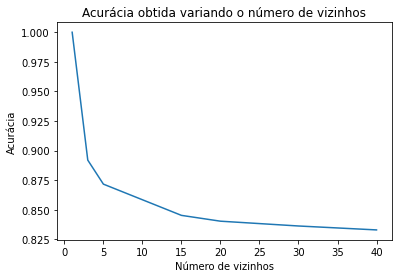

In [248]:
plt.plot([1,3,5,15,20,30,40],accuracy)
plt.xlabel("Número de vizinhos")
plt.ylabel("Acurácia")
plt.title("Acurácia obtida variando o número de vizinhos")
plt.show()

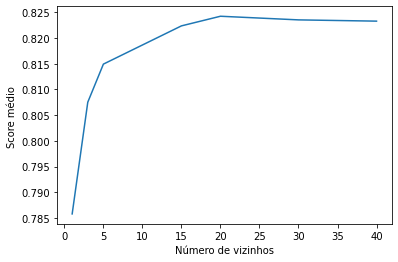

In [249]:
plt.plot([1,3,5,15,20,30,40],scores_medios)
plt.xlabel("Número de vizinhos")
plt.ylabel("Score médio ")
plt.show()

## Fontes
https://scikit-learn.org/stable/modules/preprocessing.html 

https://scikit-learn.org/stable/modules/impute.html#impute